In [1]:
import pandas as pd
import xarray as xr
import nctoolkit as nc

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

1 file was created by nctoolkit in prior or current sessions. Consider running deep_clean!
nctoolkit is using Climate Data Operators version 2.0.5


In [2]:
nc.deep_clean()

# Pepare inputs datasets

In [3]:
# NOTE: can't use glob for MOZART because there are multiple h0 files in each month's directory
date_range = pd.date_range(start="2014-09", end="2017-04", freq="1M")
mozart_paths = []
for month in date_range:
    yyyy, mm, _ = str(month).split("-")
    mozart_paths.append(
        f"../1_transport/intermediates/MOZART/output/BasisFnsUpdated/{yyyy}{mm}/"
        f"BasisFnsUpdated.mz4.h0.{yyyy}-{mm}-01-03600.nc"
    )


def prep_mozart(ds):
    ds["time"] = pd.to_datetime(ds.date.values, format="%Y%m%d") + pd.to_timedelta(
        ds.datesec.values, unit="seconds"
    )
    # extract co2 emissions array
    return ds["CO2_SRF_EMIS_avrg"]


# concatenate CO2_SRF_EMIS_avrg variable from MOZART diagnostics
with xr.open_mfdataset(
    mozart_paths,
    preprocess=prep_mozart,
    chunks={"time": 1000},
    parallel=True,
    decode_times=False,
) as ds:
    ds = ds.where(ds["time"] < pd.to_datetime("2017-04-01"), drop=True)
    da_mozart = ds["CO2_SRF_EMIS_avrg"]

# one observation for every hour of every day in study period, in units kg/m^2/s
da_mozart


<xarray.DataArray 'CO2_SRF_EMIS_avrg' (time: 22631, lat: 96, lon: 144)>
dask.array<where, shape=(22631, 96, 144), dtype=float32, chunksize=(744, 96, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 2014-09-01T01:00:00 ... 2017-03-31T23:00:00
Attributes:
    units:    KG/M^2/S

In [4]:
geoschem_glob = (
    "../1_transport/intermediates/GEOS_Chem/runs/run.v12.3.2.base/output/HEMCO_diagnostics.*.nc"
)


def prep_geoschem(ds):
    # compute the sum over the pressure levels
    return ds["EmisCO2_Total"].sum(dim=["lev"])


with xr.open_mfdataset(
    geoschem_glob, preprocess=prep_geoschem, chunks={"time": 1000}, parallel=True
) as ds:
    ds = ds.where(ds["time"] < pd.to_datetime("2017-04-01"), drop=True)
    da_geoschem = ds["EmisCO2_Total"]

# one observation for every hour of every day in study period, in units kg/m^2/s
da_geoschem


<xarray.DataArray 'EmisCO2_Total' (time: 22632, lat: 91, lon: 144)>
dask.array<where, shape=(22632, 91, 144), dtype=float32, chunksize=(744, 91, 144), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2014-09-01T00:30:00 ... 2017-03-31T23:30:00
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * lat      (lat) float64 -89.5 -88.0 -86.0 -84.0 -82.0 ... 84.0 86.0 88.0 89.5

# Produce area-weighted total monthly emitted CO2 timeseries for both datasets

In [5]:
ds = nc.from_xarray(da_mozart.isel(time=0))
ds.subset(time=0)
ds.cell_area(join=False)
da_mozart_gridbox_area = ds.to_xarray()["cell_area"]

In [6]:
# convert units from kg/m^2/s to total petagrams in the given hour
# temporal interval is hourly, conversion is 60*60=3600 (s/hr)
# include conversion to petagrams: 3600 * 1e-12 = 3.6e-9
# NOTE: this will take a few minutes
da_mozart_monthly = (
    (da_mozart * 3.6e-9 * da_mozart_gridbox_area)
    .sum(dim=["lon", "lat"])
    .sortby("time")
    .resample(time="1M")
    .sum()
)

# monthly time series in petagrams
da_mozart_monthly

<xarray.DataArray (time: 31)>
dask.array<stack, shape=(31,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2014-09-30 2014-10-31 ... 2017-03-31

In [7]:
# geoschem weights
with xr.open_dataset(
    "../1_transport/intermediates/GEOS_Chem/runs/run.v12.3.2.base/output/"
    "HEMCO_diagnostics.201409.nc"
) as ds:
    da_geoschem_gridbox_area = ds["AREA"]

# convert units from kg/m^2/s to total petagrams in the given hour
# temporal interval is hourly, conversion is 60*60=3600 (s/hr)
# include conversion to petagrams: 3600 * 1e-12 = 3.6e-9
# NOTE: this will take a few minutes
da_geoschem_monthly = (
    (da_geoschem * 3.6e-9 * da_geoschem_gridbox_area)
    .sum(dim=["lon", "lat"])
    .resample(time="1M")
    .sum()
)

# monthly time series in petagrams
da_geoschem_monthly


<xarray.DataArray (time: 31)>
dask.array<stack, shape=(31,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2014-09-30 2014-10-31 ... 2017-03-31

In [8]:
# compute the difference of the two time series
da_difference = da_geoschem_monthly - da_mozart_monthly

## Plot individual time series and difference

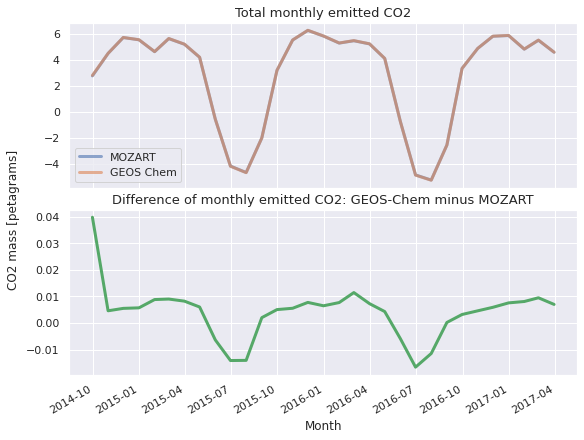

In [9]:
fig, axes = plt.subplots(2, 1, figsize=[8, 6], sharex=True, constrained_layout=True)

da_mozart_monthly.plot(ax=axes[0], linewidth=3, alpha=0.6, label="MOZART")
da_geoschem_monthly.plot(ax=axes[0], linewidth=3, alpha=0.6, label="GEOS Chem")
axes[0].set_title("Total monthly emitted CO2", fontsize=13)
axes[0].set_xlabel(None)
axes[0].legend()

da_difference.plot(ax=axes[1], linewidth=3, color="#55a868")
axes[1].set_title("Difference of monthly emitted CO2: GEOS-Chem minus MOZART", fontsize=13)
axes[1].set_xlabel("Month", fontsize=12)

fig.supylabel("CO2 mass [petagrams]", fontsize=12)
fig.savefig("../figures/timeseries_global_monthly_total_inputs.png", dpi=200);
